**Initialization**

*Setting up Fast.ai Environment.*

In [1]:
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Dependencies**

In [3]:
from fastai.collab import *
from fastai.tabular import *

### **Collaborative Filtering**

In [4]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [5]:
ratings = pd.read_csv(path/"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


**Training the Model.**

In [8]:
np.random.seed(42)
data = CollabDataBunch.from_df(ratings)

In [9]:
y_range = [0, 5.5]

In [10]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

epoch,train_loss,valid_loss,time
0,1.833744,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


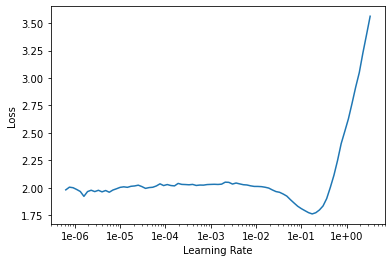

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(3, 1e-01)

epoch,train_loss,valid_loss,time
0,2.014817,3.386018,00:00
1,3.381311,3.702949,00:00
2,3.314078,3.463302,00:00


#### **Movielens 100K**

In [23]:
path = Config.data_path()/'ml-100k'
path

PosixPath('/root/.fastai/data/ml-100k')

In [24]:
user, item, title = 'userId', 'movieId', 'title'

In [21]:
!unzip /content/data/ml-100k.zip

Archive:  /content/data/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [25]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [30]:
len(ratings)

100000

In [31]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [33]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [34]:
data.show_batch()

userId,title,target
177,"Princess Bride, The (1987)",4.0
766,Once Upon a Time in the West (1969),4.0
887,Forrest Gump (1994),4.0
401,Courage Under Fire (1996),4.0
711,"Madness of King George, The (1994)",5.0


In [35]:
y_range = [0, 5.5]

In [36]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-01)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


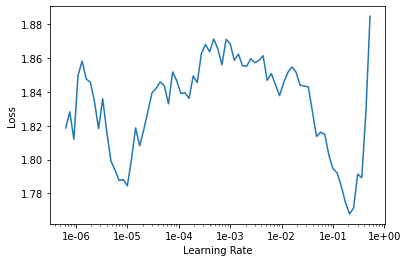

In [37]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [38]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,time
0,2.243710,2.259651,00:09
1,2.799214,2.772840,00:09
2,1.981016,1.939480,00:09
3,1.095620,1.076330,00:09
4,0.821612,0.882704,00:09


In [39]:
learn.save('dotprod')

#### **Interpretation**

In [40]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [41]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [42]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

#### **Movie Bias**

In [43]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [45]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies, movie_bias)]

In [46]:
item0 = lambda x:x[0]

In [47]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.6526),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.5741), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.5626), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.5372), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.5251), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.5163), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.5064), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.4973),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4748), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.4611), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.4594), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.4426), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.4355), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.4346), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.4288

In [48]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(1.0409), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.9490), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.9213), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.9207), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.8705), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.8506), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.8497), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.8422), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.8317), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.8289), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.8272), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.8241), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.8221), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.8076), 'Empire Strikes Back, The (1980)', 4.204359673024523),
 (tensor(0.7933), 'Vertigo (1958)', 4.251396648044692)]

### **Movie Weights**

In [49]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [51]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0139), 'When We Were Kings (1996)'),
 (tensor(0.8782), 'Chinatown (1974)'),
 (tensor(0.8312), 'Apocalypse Now (1979)'),
 (tensor(0.8060), 'Lone Star (1996)'),
 (tensor(0.7983), 'Citizen Kane (1941)'),
 (tensor(0.7887), 'Night on Earth (1991)'),
 (tensor(0.7882), 'Big Night (1996)'),
 (tensor(0.7820), 'Welcome to the Dollhouse (1995)'),
 (tensor(0.7795), 'City of Lost Children, The (1995)'),
 (tensor(0.7501), 'Belle de jour (1967)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9684), 'Ghost and the Darkness, The (1996)'),
 (tensor(-0.8353), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8028), 'Top Gun (1986)'),
 (tensor(-0.7942), 'Twister (1996)'),
 (tensor(-0.7859), 'First Knight (1995)'),
 (tensor(-0.7796), 'Anastasia (1997)'),
 (tensor(-0.7786), 'Just Cause (1995)'),
 (tensor(-0.7575), 'Dirty Dancing (1987)'),
 (tensor(-0.7566), 'Trial and Error (1997)'),
 (tensor(-0.7452), 'Relic, The (1997)')]

In [54]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7842), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.7774), 'Braveheart (1995)'),
 (tensor(0.7248), 'Empire Strikes Back, The (1980)'),
 (tensor(0.6895), 'Lion King, The (1994)'),
 (tensor(0.6593), 'Star Wars (1977)'),
 (tensor(0.6403), "It's a Wonderful Life (1946)"),
 (tensor(0.6388), 'African Queen, The (1951)'),
 (tensor(0.6349), 'Crimson Tide (1995)'),
 (tensor(0.6285), 'Pinocchio (1940)'),
 (tensor(0.6239), 'Lawrence of Arabia (1962)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8114), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.7810), 'Leave It to Beaver (1997)'),
 (tensor(-0.6260), 'Wings of Desire (1987)'),
 (tensor(-0.6250), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.6208), 'Keys to Tulsa (1997)'),
 (tensor(-0.6163), 'Kids (1995)'),
 (tensor(-0.6008), 'Anaconda (1997)'),
 (tensor(-0.5707), 'Vegas Vacation (1997)'),
 (tensor(-0.5379), 'Black Sheep (1996)'),
 (tensor(-0.5247), 'Event Horizon (1997)')]

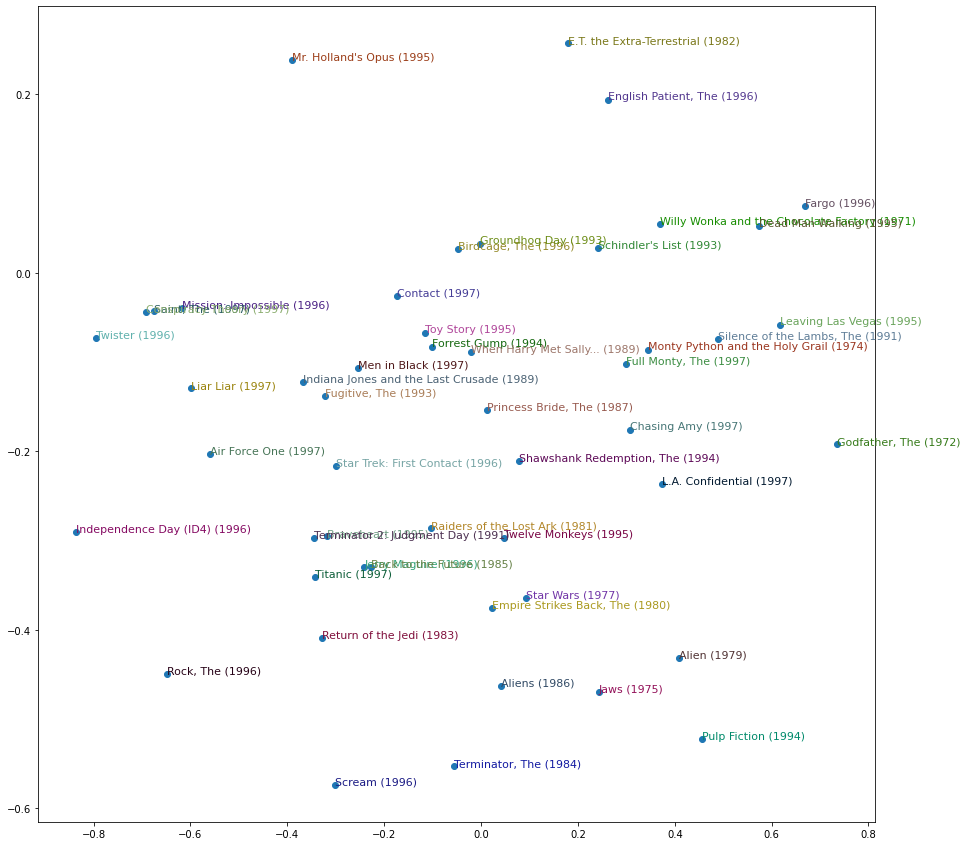

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15, 15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()